In [2]:
%load_ext autoreload
%autoreload 2

# Proof of concept

In [2]:
# Torch device management
import torch

if torch.cuda.is_available():
    torch.cuda.set_device(0)
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: cuda


In [3]:
import embedders

In [4]:
# Load Polblogs

polblogs_dists, polblogs_labels = embedders.dataloaders.load(
    "polblogs",
    labels=True,
    polblogs_path="/Users/phil/embedders/data/graphs/polblogs.mtx",
    polblogs_labels_path="/Users/phil/embedders/data/graphs/polblogs_labels.tsv",
)

Top CC has 1222 nodes; original graph has 1490 nodes.


In [5]:
# Specify signature - useful to re-initialize the manifold here

torch.manual_seed(0)  # Not all seeds are stable - this one trains for 3000 iterations at lr=1e-2 (burn-in 1e-3)

signature = [(-1, 6)]
pm = embedders.manifolds.ProductManifold(signature=signature)
print(pm.name)

# Rescale distances
dists_rescaled = polblogs_dists / polblogs_dists.max()

# Get embedding
embedders.coordinate_learning.train_coords(
    pm,
    dists_rescaled,
    device=device,
    burn_in_iterations=300,
    training_iterations=300 * 9,
    learning_rate=1e-1,
    burn_in_learning_rate=1e-2,
    scale_factor_learning_rate=1e-1,
)

h6_polblogs = pm.x_embed.detach().cpu().numpy()

H_1.0^6


  0%|          | 0/3000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [22]:
# Compare productDT and sklearn on this dataset
# from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

# from hyperdt.tree import HyperbolicDecisionTreeClassifier
from embedders.tree_new import ProductSpaceDT
from sklearn.tree import DecisionTreeClassifier

X_train, X_test, y_train, y_test = train_test_split(h6_polblogs, polblogs_labels.values, test_size=0.2, random_state=0)

pdt = ProductSpaceDT(pm=pm, max_depth=3, use_special_dims=True)
pdt.fit(X_train, y_train)
pdt_f1 = f1_score(y_test, pdt.predict(X_test))
print(f"ProductDT\t{pdt_f1*100:.2f}")

dt = DecisionTreeClassifier(max_depth=3)
dt.fit(X_train, y_train)
dt_f1 = f1_score(y_test, dt.predict(X_test))
print(f"DT\t{dt_f1*100:.2f}")

ProductDT	89.23
DT	89.31


In [23]:
# Same thing, but now we do H2 x E2 x S2
torch.manual_seed(0)

signature = [(-1, 2), (0, 2), (1, 2)]
pm2 = embedders.manifolds.ProductManifold(signature=signature)
print(pm2.name)

# Get embedding
embedders.coordinate_learning.train_coords(
    pm2,
    dists_rescaled,
    device=device,
    burn_in_iterations=300,
    training_iterations=300 * 9,
    learning_rate=1e-1,
    burn_in_learning_rate=1e-2,
    scale_factor_learning_rate=1e-1,
)

h2_e2_s2_polblogs = pm2.x_embed.detach().cpu().numpy()

H_1.0^2 x E_0.0^2 x S_1.0^2


  0%|          | 0/3000 [00:00<?, ?it/s]

In [24]:
# Compare productDT and sklearn on this dataset
from sklearn.tree import DecisionTreeClassifier

X_train, X_test, y_train, y_test = train_test_split(
    h2_e2_s2_polblogs, polblogs_labels.values, test_size=0.2, random_state=0
)

pdt2 = ProductSpaceDT(pm=pm2, max_depth=3)
pdt2.fit(X_train, y_train)
pdt2_f1 = f1_score(y_test, pdt2.predict(X_test))
print(f"ProductDT\t{pdt2_f1*100:.2f}")

dt = DecisionTreeClassifier(max_depth=3)
dt.fit(X_train, y_train)
dt_f1 = f1_score(y_test, dt.predict(X_test))
print(f"DT\t{dt_f1*100:.2f}")
# cv_eval(dt, "DT", h2_e2_s2_polblogs, polblogs_labels)

# TODO: Quentin: product perceptron eval
# TODO: Quentin: product SVM eval

ProductDT	90.57
DT	88.46


In [10]:
# Does it hold up componentwise?

# Hyperbolic
pdt_H = ProductSpaceDT(max_depth=3, signature=[(2, -1.0)])
cv_eval(pdt_H, "ProductDT (H)", h2_e2_s2_polblogs[:, pm2.man2dim[0]], polblogs_labels)

hdt_H = HyperbolicDecisionTreeClassifier(max_depth=3, skip_hyperboloid_check=True)
cv_eval(hdt_H, "HyperDT (H)", h2_e2_s2_polblogs[:, pm2.man2dim[0]], polblogs_labels)

dt_H = DecisionTreeClassifier(max_depth=3)
cv_eval(dt_H, "DT (H)", h2_e2_s2_polblogs[:, pm2.man2dim[0]], polblogs_labels)

# TODO: Quentin: product perceptron eval
# TODO: Quentin: product SVM eval

print()

# Euclidean
# For the euclidean ones, we won't use man2dim because fix_X() breaks it - we'll hardcode 3:6 instead
pdt_E = ProductSpaceDT(max_depth=3, signature=[(2, 0.0)])
cv_eval(pdt_E, "ProductDT (E)", fix_X(h2_e2_s2_polblogs)[:, 3:6], polblogs_labels)

dt_E = DecisionTreeClassifier(max_depth=3)
cv_eval(dt_E, "DT (E)", h2_e2_s2_polblogs[:, pm2.man2dim[1]], polblogs_labels)

# TODO: Quentin: product perceptron eval
# TODO: Quentin: product SVM eval

print()

# Sphere
pdt_S = ProductSpaceDT(max_depth=3, signature=[(2, 1.0)])
cv_eval(pdt_S, "ProductDT (S)", h2_e2_s2_polblogs[:, pm2.man2dim[2]], polblogs_labels)

hdt_S = HyperbolicDecisionTreeClassifier(max_depth=3, skip_hyperboloid_check=True, angle_midpoint_method="bisect")
cv_eval(hdt_S, "HyperDT (S)", h2_e2_s2_polblogs[:, pm2.man2dim[2]], polblogs_labels)

dt_S = DecisionTreeClassifier(max_depth=3)
cv_eval(dt_S, "DT (S)", h2_e2_s2_polblogs[:, pm2.man2dim[2]], polblogs_labels)

# TODO: Quentin: product perceptron eval
# TODO: Quentin: product SVM eval

ProductDT (H)	70.13 +/- 2.41
HyperDT (H)	70.13 +/- 2.41
DT (H)	68.98 +/- 3.30

ProductDT (E)	81.34 +/- 4.06
DT (E)	81.34 +/- 4.06

ProductDT (S)	90.26 +/- 1.02
HyperDT (S)	90.26 +/- 1.02
DT (S)	90.67 +/- 1.59


In [54]:
contributions = embedders.metrics.dist_component_by_manifold(pm2, pm2.x_embed)

# Why don't these add to 100%...?
print(contributions)
print(sum(contributions))

[0.25659456849098206, 0.3267468214035034, 0.4166586697101593]
1.0000000596046448


# Exhaustive benchmark

In [3]:
# Non-Gu signature selection
SIGNATURES = [
    [(-1, 2), (-1, 2)],  # HH
    [(-1, 2), (0, 2)],  # HE
    [(-1, 2), (1, 2)],  # HS
    [(1, 2), (1, 2)],  # SS
    [(1, 2), (0, 2)],  # SE
    [(-1, 4)],  # H
    [(0, 4)],  # E
    [(1, 4)],  # S
]

SIGNATURES_STR = ["HH", "HE", "HS", "SS", "SE", "H", "E", "S"]

In [4]:
import torch
import embedders
import numpy as np

# device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# device
if torch.cuda.is_available():
    device = torch.device("cuda")
# elif torch.backends.mps.is_available(): # No MPS - float64 not supported
#     device = torch.device("mps")
else:
    device = torch.device("cpu")
device

device(type='cuda')

## Generate embeddings

In [5]:
# Hyperparameters

DOWNSAMPLE = None
# DATASET = "cora"
# DATASET = "citeseer"
DATASET = "pubmed"
ITERS = 2_000
TRIALS = 10

In [1]:
# For Lightning - change directory

import os 

if not os.getcwd().endswith("notebooks"):
    os.chdir("embedders/notebooks")
print(os.getcwd())

/teamspace/studios/this_studio/embedders/notebooks


In [8]:
# Get data

dists, labels = embedders.dataloaders.load(DATASET, labels=True)
dists_rescaled = dists / dists.max()
dists_rescaled = torch.tensor(dists_rescaled, dtype=torch.float32).to(device)
labels = torch.tensor(labels, dtype=torch.long).to(device)

Top CC has 19717 nodes; original graph has 19717 nodes.


In [13]:
from embedders.metrics import d_avg
import pandas as pd
import os

results = []
for i, (signature, signature_str) in enumerate(zip(SIGNATURES, SIGNATURES_STR)):
    for j in range(TRIALS):
        # Get manifold
        pm = embedders.manifolds.ProductManifold(signature=signature).to(device)
        
        # Skip existing
        if os.path.exists(f"../data/graphs/embeddings/{DATASET}/{signature_str}_{j}.npy"):
            x_embed = np.load(f"../data/graphs/embeddings/{DATASET}/{signature_str}_{j}.npy")
            x_embed = torch.tensor(x_embed, dtype=torch.float32).to(device)

            my_d_avg = d_avg(pm.pdist(x_embed), dists_rescaled[:DOWNSAMPLE, :DOWNSAMPLE]).item()
            results.append({"signature": signature, "seed": j, "d_avg": my_d_avg})
            print(f"Skipping {signature_str}_{j}")
            continue

        seed = i * TRIALS + j  # Unique seed
        torch.manual_seed(seed)

        # Generate embedding
        x_embed, losses = embedders.coordinate_learning.train_coords(
            pm,
            dists_rescaled[:DOWNSAMPLE, :DOWNSAMPLE],
            device=device,
            burn_in_iterations=int(ITERS * 0.1),
            training_iterations=int(ITERS * 0.9),
            learning_rate=1e-1,
            burn_in_learning_rate=1e-2,
            scale_factor_learning_rate=1e-2,
        )

        # Calculate d_avg
        my_d_avg = d_avg(pm.pdist(x_embed), dists_rescaled[:DOWNSAMPLE, :DOWNSAMPLE]).item()

        # Save embeddings
        np.save(
            f"../data/graphs/embeddings/{DATASET}/{signature_str}_{j}.npy",
            pm.x_embed.detach().cpu().numpy(),
        )

        # Results should just be average distances
        results.append({"signature": signature, "seed": seed, "d_avg": my_d_avg})

results_df = pd.DataFrame(results)
results_df.to_csv(f"../data/graphs/embeddings/{DATASET}_dists.tsv", sep="\t")

Skipping HH_0
Skipping HH_1
Skipping HH_2
Skipping HH_3
Skipping HH_4
Skipping HH_5
Skipping HH_6
Skipping HH_7
Skipping HH_8
Skipping HH_9
Skipping HE_0
Skipping HE_1
Skipping HE_2
Skipping HE_3
Skipping HE_4
Skipping HE_5
Skipping HE_6
Skipping HE_7
Skipping HE_8
Skipping HE_9
Skipping HS_0
Skipping HS_1
Skipping HS_2
Skipping HS_3
Skipping HS_4
Skipping HS_5
Skipping HS_6
Skipping HS_7
Skipping HS_8
Skipping HS_9
Skipping SS_0
Skipping SS_1
Skipping SS_2
Skipping SS_3
Skipping SS_4
Skipping SS_5
Skipping SS_6
Skipping SS_7
Skipping SS_8
Skipping SS_9
Skipping SE_0
Skipping SE_1
Skipping SE_2
Skipping SE_3
Skipping SE_4
Skipping SE_5
Skipping SE_6
Skipping SE_7
Skipping SE_8
Skipping SE_9
Skipping H_0
Skipping H_1
Skipping H_2
Skipping H_3
Skipping H_4
Skipping H_5
Skipping H_6
Skipping H_7
Skipping H_8
Skipping H_9
Skipping E_0
Skipping E_1
Skipping E_2
Skipping E_3
Skipping E_4
Skipping E_5
Skipping E_6
Skipping E_7
Skipping E_8
Skipping E_9
Skipping S_0
Skipping S_1
Skipping S_2
S

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [59]:
# Get data

cs_phds_dists, cs_phds_labels = embedders.dataloaders.load(
    "cs_phds",
    labels=True,
    cs_phds_path="/Users/phil/embedders/data/graphs/cs_phds.txt",
)
dists_rescaled = cs_phds_dists / cs_phds_dists.max()
cs_phds_dists = torch.tensor(cs_phds_dists, dtype=torch.float32).to(device)
cs_phds_labels = torch.tensor(cs_phds_labels, dtype=torch.long).to(device)

Top CC has 1025 nodes; original graph has 1025 nodes.


In [60]:
results = []
for i, (signature, signature_str) in enumerate(zip(SIGNATURES, SIGNATURES_STR)):
    for j in range(TRIALS):
        # Skip existing
        if os.path.exists(f"../data/graphs/embeddings/cs_phds/{signature_str}_{j}.npy"):
            continue

        seed = i * TRIALS + j  # Unique seed
        torch.manual_seed(seed)

        # Generate embedding
        pm = embedders.manifolds.ProductManifold(signature=signature).to(device)
        x_embed, losses = embedders.coordinate_learning.train_coords(
            pm,
            dists_rescaled[:DOWNSAMPLE, :DOWNSAMPLE],
            device=device,
            burn_in_iterations=int(ITERS * 0.1),
            training_iterations=int(ITERS * 0.9),
            learning_rate=1e-1,
            burn_in_learning_rate=1e-2,
            scale_factor_learning_rate=1e-2,
        )

        # Calculate d_avg
        my_d_avg = d_avg(pm.pdist(x_embed), dists_rescaled[:DOWNSAMPLE, :DOWNSAMPLE]).item()

        # Save embeddings
        np.save(
            f"../data/graphs/embeddings/cs_phds/{signature_str}_{j}.npy",
            pm.x_embed.detach().cpu().numpy(),
        )

        # Results should just be average distances
        results.append({"signature": signature, "seed": seed, "d_avg": my_d_avg})

results = pd.DataFrame(results)
results.to_csv("../data/graphs/embeddings/cs_phds_dists.tsv", sep="\t")

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [147]:
# Get data - Cora

cora_dists, cora_labels = embedders.dataloaders.load("cora", labels=True)
dists_rescaled = cora_dists / cora_dists.max()
cora_dists = torch.tensor(cora_dists, dtype=torch.float32).to(device)
cora_labels = torch.tensor(cora_labels, dtype=torch.long).to(device)

Top CC has 2485 nodes; original graph has 2708 nodes.


In [150]:
DATASET = "cora"

results = []
for i, (signature, signature_str) in enumerate(zip(SIGNATURES, SIGNATURES_STR)):
    for j in range(TRIALS):
        # Skip existing
        if os.path.exists(f"../data/graphs/embeddings/{DATASET}/{signature_str}_{j}.npy"):
            continue

        seed = i * TRIALS + j  # Unique seed
        torch.manual_seed(seed)

        # Generate embedding
        pm = embedders.manifolds.ProductManifold(signature=signature).to(device)
        x_embed, losses = embedders.coordinate_learning.train_coords(
            pm,
            dists_rescaled[:DOWNSAMPLE, :DOWNSAMPLE],
            device=device,
            burn_in_iterations=int(ITERS * 0.1),
            training_iterations=int(ITERS * 0.9),
            learning_rate=1e-1,
            burn_in_learning_rate=1e-2,
            scale_factor_learning_rate=1e-2,
        )

        # Calculate d_avg
        my_d_avg = d_avg(pm.pdist(x_embed), dists_rescaled[:DOWNSAMPLE, :DOWNSAMPLE]).item()

        # Save embeddings
        np.save(
            f"../data/graphs/embeddings/{DATASET}/{signature_str}_{j}.npy",
            pm.x_embed.detach().cpu().numpy(),
        )

        # Results should just be average distances
        results.append({"signature": signature, "seed": seed, "d_avg": my_d_avg})

results = pd.DataFrame(results)
results.to_csv(f"../data/graphs/embeddings/{DATASET}_dists.tsv", sep="\t")

  0%|          | 0/2000 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Evaluate

In [143]:
# Run benchmarks
import torch
import pandas as pd
from tqdm.notebook import tqdm

# Params
TRIALS = 10
MAX_DEPTH = 3
# DATASET = "polblogs"
# DATASET = "cs_phds"
DATASET = "cora"

TASK = "regression" if DATASET == "cs_phds" else "classification"
SCORE = "f1-micro" if TASK == "classification" else "rmse"

# Get data
_, y = embedders.dataloaders.load(
    DATASET,
    labels=True,
    # polblogs_path="/Users/phil/embedders/data/graphs/polblogs.mtx",
    # polblogs_labels_path="/Users/phil/embedders/data/graphs/polblogs_labels.tsv",
    # cs_phds_path="/Users/phil/embedders/data/graphs/cs_phds.txt",
)
# y = torch.tensor(y.values)
y = torch.tensor(y)

# Benchmark loop
results = []
with torch.no_grad():
    my_tqdm = tqdm(total=TRIALS * len(SIGNATURES))
    for i, (signature, signature_str) in enumerate(zip(SIGNATURES, SIGNATURES_STR)):
        pm = embedders.manifolds.ProductManifold(signature=signature)
        for j in range(TRIALS):
            X = np.load(f"../data/graphs/embeddings/{DATASET}/{signature_str}_{j}.npy")
            X = torch.tensor(X)
            if X.isnan().any():
                print(i, j, "NaN")
                break

            # Run benchmarks
            seed = i * TRIALS + j
            accs = embedders.benchmarks.benchmark(X, y, pm, max_depth=MAX_DEPTH, task=TASK, score=SCORE, seed=seed)
            accs["signature"] = signature_str
            accs["seed"] = seed
            results.append(accs)

            my_tqdm.update(1)

results = pd.DataFrame(results)

Top CC has 1025 nodes; original graph has 1025 nodes.


  0%|          | 0/80 [00:00<?, ?it/s]

In [118]:
# Add distances
dists = pd.read_table(f"../data/graphs/embeddings/{DATASET}_dists.tsv", index_col=0)
dists = dists.drop(columns=["signature"])
results_merged = results.merge(dists, on=["seed"])
results_grouped = results_merged.groupby(["signature"]).mean()
results_grouped

,sklearn_dt,sklearn_rf,product_dt,product_rf,tangent_dt,tangent_rf,knn,ps_perceptron,seed,d_avg
signature,,,,,,,,,,
E,15.468557,14.362406,15.428887,14.535590,15.463526,14.362406,13.628535,20.679334,64.5,0.093378
H,16.827143,15.423731,16.073031,15.517410,16.816113,15.402290,14.218217,21.870253,54.5,0.091277
HE,15.720164,14.487622,15.617892,14.607355,15.907300,14.470194,13.802418,21.100839,14.5,0.092342
HH,15.334424,14.101544,15.681947,14.287518,15.166246,14.276959,13.112252,56.725787,5.0,0.091501
HS,15.812613,14.266390,15.210592,14.608781,16.023448,14.391298,13.185946,20.938904,24.5,0.092177
S,15.084100,13.859736,15.329632,13.978454,16.347620,14.217066,13.130431,20.329931,74.5,0.093538
SE,15.343300,14.689015,16.236239,14.899259,15.513023,14.776725,13.379728,21.131770,44.5,0.092496
SS,14.609547,13.802897,15.177632,14.060737,15.124642,14.092233,13.125383,20.035095,34.5,0.091443


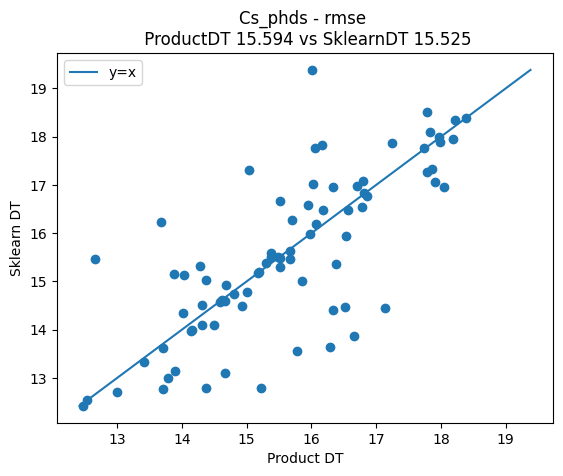

In [129]:
import matplotlib.pyplot as plt

plt.scatter(results["product_dt"], results["sklearn_dt"])
plt.ylabel("Sklearn DT")
plt.xlabel("Product DT")
mymin = results[["product_dt", "sklearn_dt"]].min().min()
mymax = results[["product_dt", "sklearn_dt"]].max().max()
plt.plot([mymin, mymax], [mymin, mymax], label="y=x")
plt.title(
    f"{DATASET.capitalize()} - {SCORE} \n ProductDT {results_grouped['product_dt'].mean():.3f} vs SklearnDT {results_grouped['sklearn_dt'].mean():.3f}"
)
plt.legend()

plt.show()

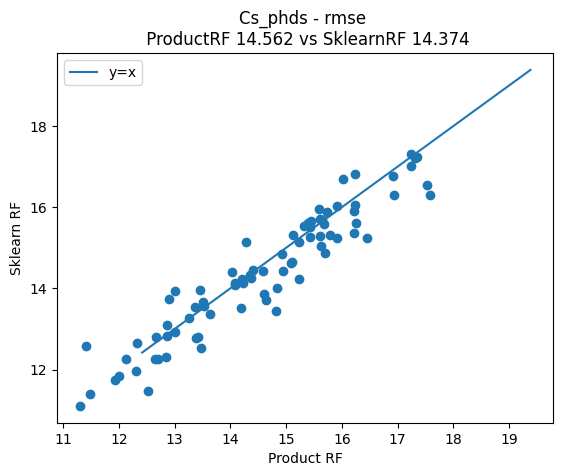

In [131]:
import matplotlib.pyplot as plt

plt.scatter(results["product_rf"], results["sklearn_rf"])
plt.ylabel("Sklearn RF")
plt.xlabel("Product RF")
plt.plot([mymin, mymax], [mymin, mymax], label="y=x")
plt.title(
    f"{DATASET.capitalize()} - {SCORE} \n ProductRF {results_grouped['product_rf'].mean():.3f} vs SklearnRF {results_grouped['sklearn_rf'].mean():.3f}"
)
plt.legend()

plt.show()

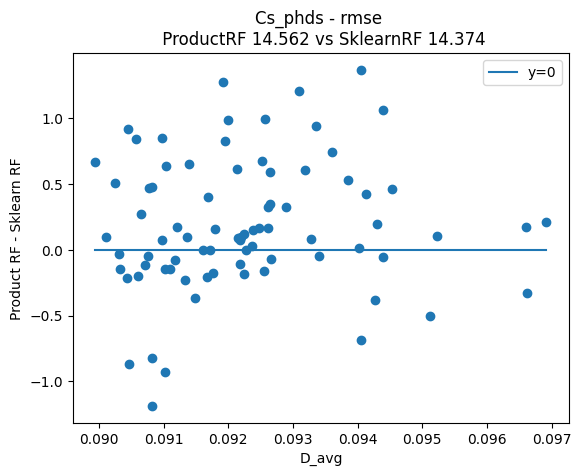

In [140]:
import matplotlib.pyplot as plt

plt.scatter(results_merged["d_avg"], results_merged["product_rf"] - results_merged["sklearn_rf"])
plt.ylabel("Product RF - Sklearn RF")
plt.xlabel("D_avg")
# plt.plot([0.8, 1], [0.8, 1], label="y=x")
# plt.hlines(0, 0.8, 1, label="y=0")
plt.plot([results_merged["d_avg"].min(), results_merged["d_avg"].max()], [0, 0], label="y=0")
plt.title(
    f"{DATASET.capitalize()} - {SCORE} \n ProductRF {results_grouped['product_rf'].mean():.3f} vs SklearnRF {results_grouped['sklearn_rf'].mean():.3f}"
)
plt.legend()

plt.show()

In [141]:
results_grouped.sort_values("d_avg")

,sklearn_dt,sklearn_rf,product_dt,product_rf,tangent_dt,tangent_rf,knn,ps_perceptron,seed,d_avg
signature,,,,,,,,,,
H,16.827143,15.423731,16.073031,15.517410,16.816113,15.402290,14.218217,21.870253,54.5,0.091277
SS,14.609547,13.802897,15.177632,14.060737,15.124642,14.092233,13.125383,20.035095,34.5,0.091443
HH,15.334424,14.101544,15.681947,14.287518,15.166246,14.276959,13.112252,56.725787,5.0,0.091501
HS,15.812613,14.266390,15.210592,14.608781,16.023448,14.391298,13.185946,20.938904,24.5,0.092177
HE,15.720164,14.487622,15.617892,14.607355,15.907300,14.470194,13.802418,21.100839,14.5,0.092342
SE,15.343300,14.689015,16.236239,14.899259,15.513023,14.776725,13.379728,21.131770,44.5,0.092496
E,15.468557,14.362406,15.428887,14.535590,15.463526,14.362406,13.628535,20.679334,64.5,0.093378
S,15.084100,13.859736,15.329632,13.978454,16.347620,14.217066,13.130431,20.329931,74.5,0.093538
